# 调入所需要的库

In [1]:
import pandas as pd
data = pd.read_csv('train.csv')

In [2]:
import matplotlib.pyplot as plt

In [3]:
import numpy as np

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import StandardScaler
import category_encoders as ce
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import cross_val_score, KFold, train_test_split

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
# Regressors
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso

sns.set(rc={'figure.figsize':(12,8.27)})

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


In [5]:
import sklearn
sklearn.__version__

'0.23.2'

In [6]:
from sklearn.model_selection import train_test_split

#Pipelines
from sklearn.pipeline import Pipeline

#Transformers
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

#The models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

#Metrics & evaluation
from sklearn.metrics import mean_squared_error

#Visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [7]:
def train_models(X,y,kfolds=12):
    kfold = KFold(kfolds)
    for model in models:
     # model['regressor'].fit(X,y)
        cf_result =  cross_val_score(model['regressor'], X, y, cv=kfold,scoring='neg_mean_squared_log_error')
        model['cv_results'] = np.sqrt(cf_result*-1)
        msg = f"Regressor: {model['name']},   rmsle:{cf_result.mean().round(11)} " 
        print(msg)

In [8]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

# 导入数据

In [9]:
original_train = pd.read_csv('train.csv')
original_test = pd.read_csv('test.csv')

y_column = 'SalePrice'
original_train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [10]:
train = original_train.copy().drop(columns=['Id'])
test = original_test.copy()

# 基本数据描述

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


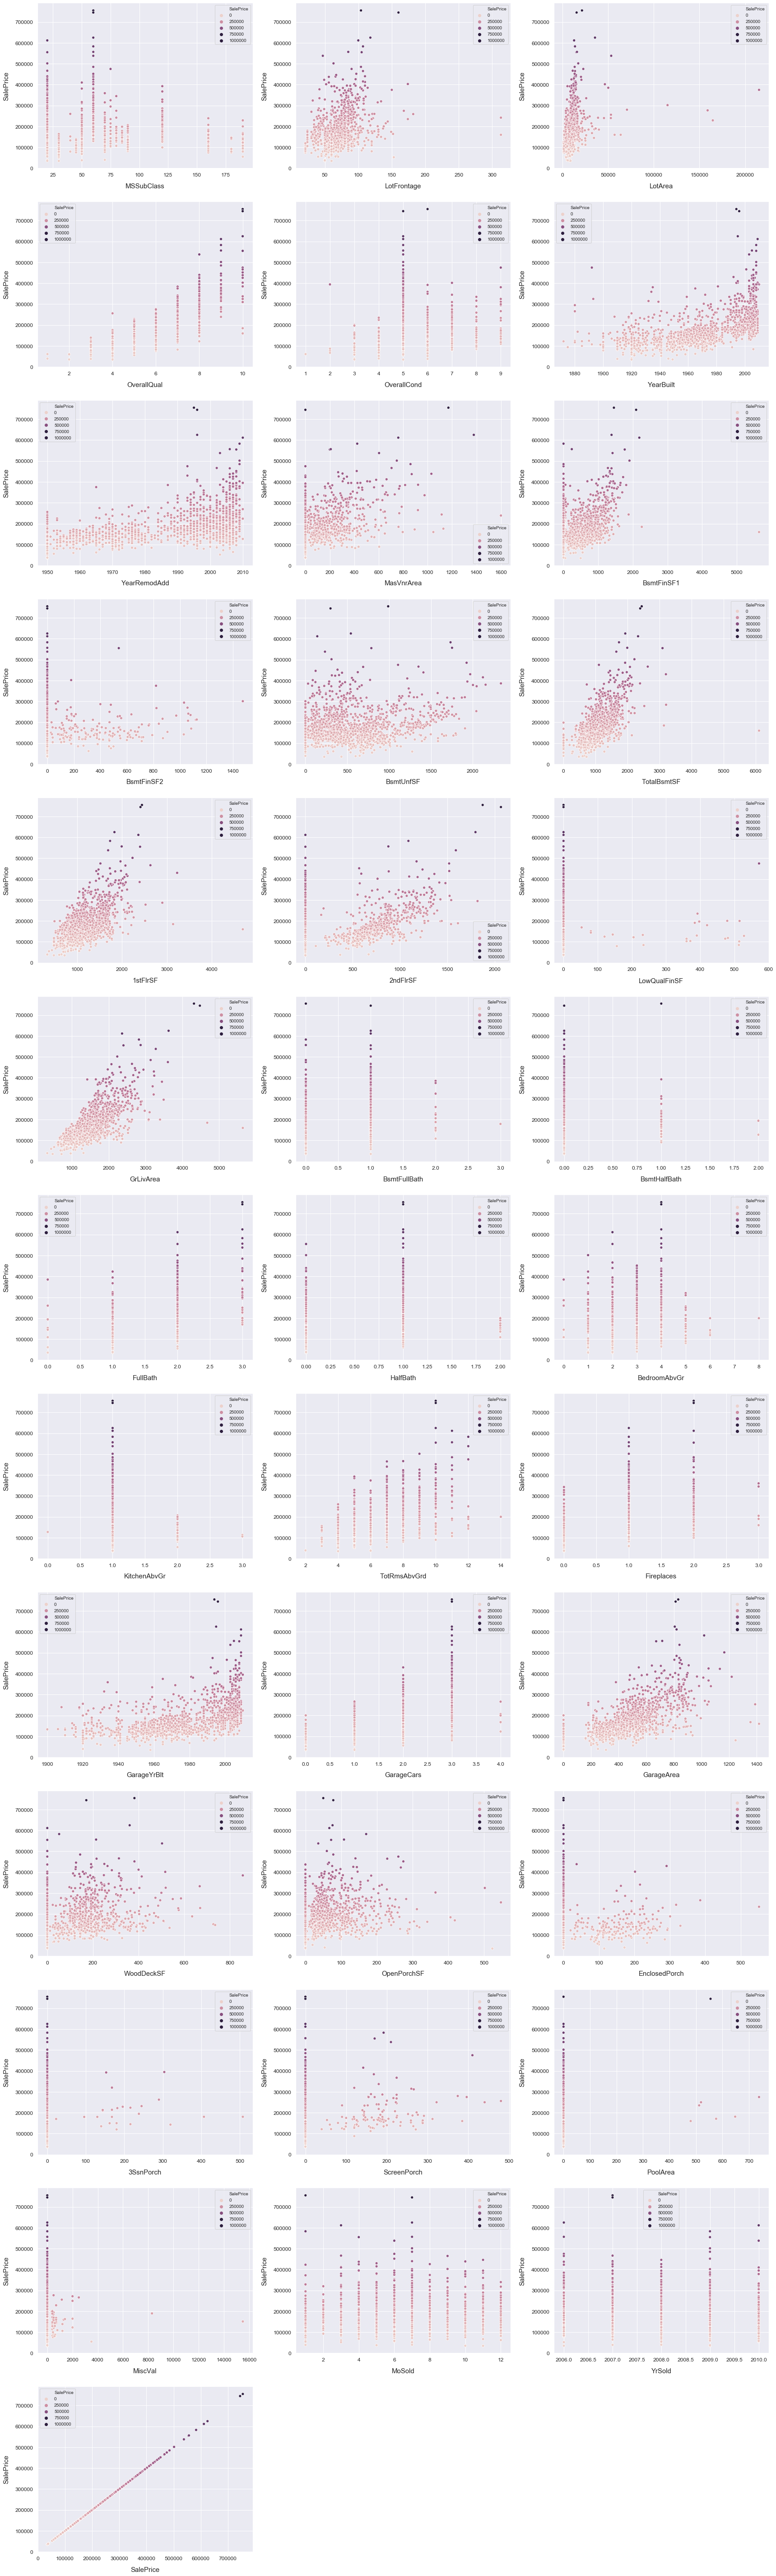

In [142]:
numeric_features = train.drop(train.select_dtypes([object]), axis = 1)
   
# visualising some  outliers in the data values
fig, axs = plt.subplots(ncols=2, nrows=0, figsize=(12, 120))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)


for (i,feature) in enumerate(numeric_features.columns,1):
    plt.subplot(len(numeric_features.columns), 3, i)
    sns.scatterplot(x=feature, y='SalePrice', hue='SalePrice', data=train)
    print(type(feature))
    plt.xlabel(str(feature), size=15,labelpad=12.5)
    plt.ylabel('SalePrice', size=15, labelpad=12.5)
    
    for j in range(2):
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)
    
    plt.legend(loc='best', prop={'size': 10})
        
plt.show()

# 相关性描述

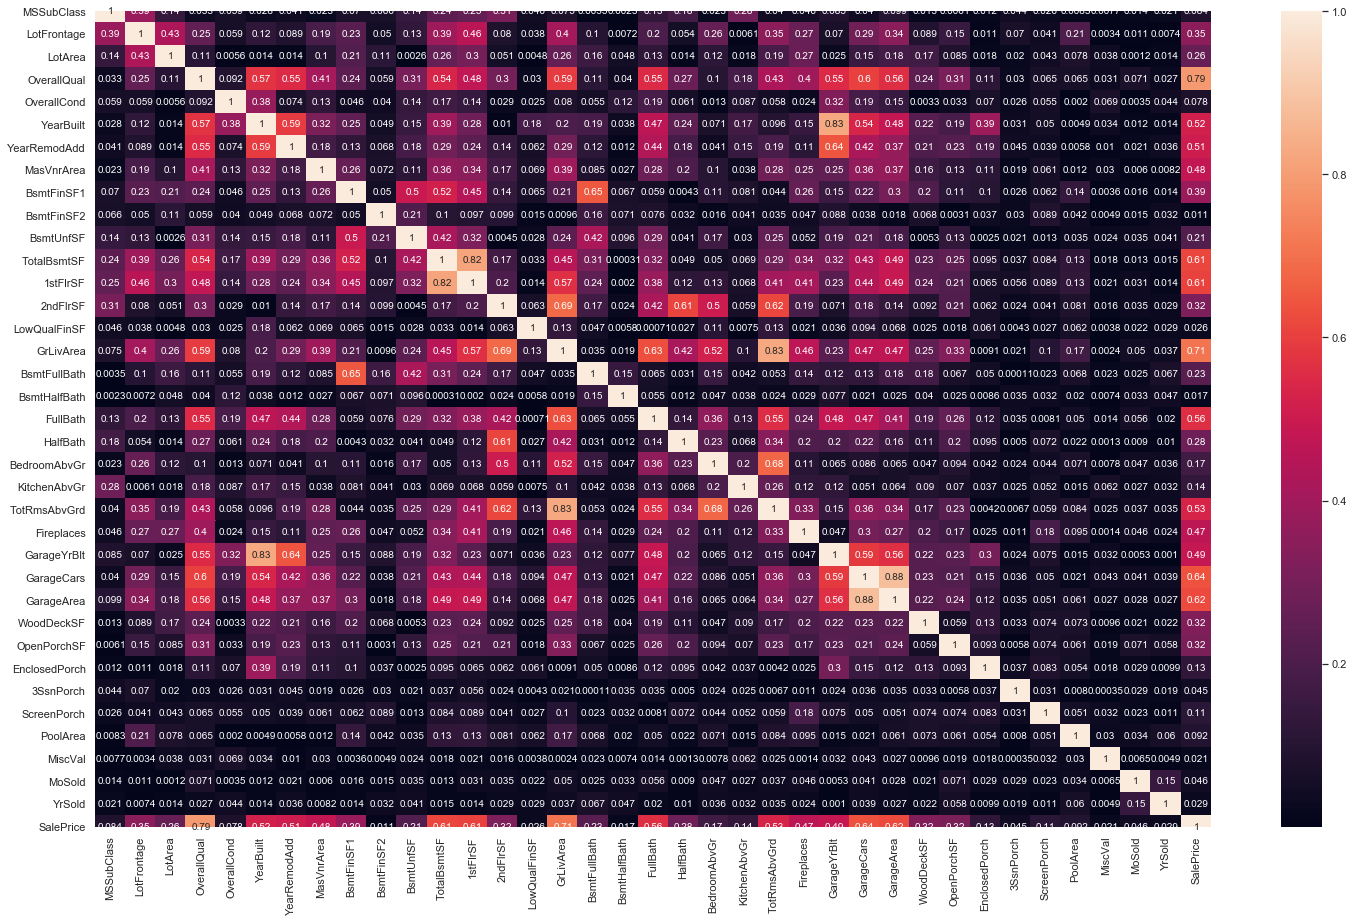

In [134]:
fig, ax = plt.subplots(figsize=(25,15))         # Sample figsize in inches
sns.heatmap(train.corr().abs(),annot=True)

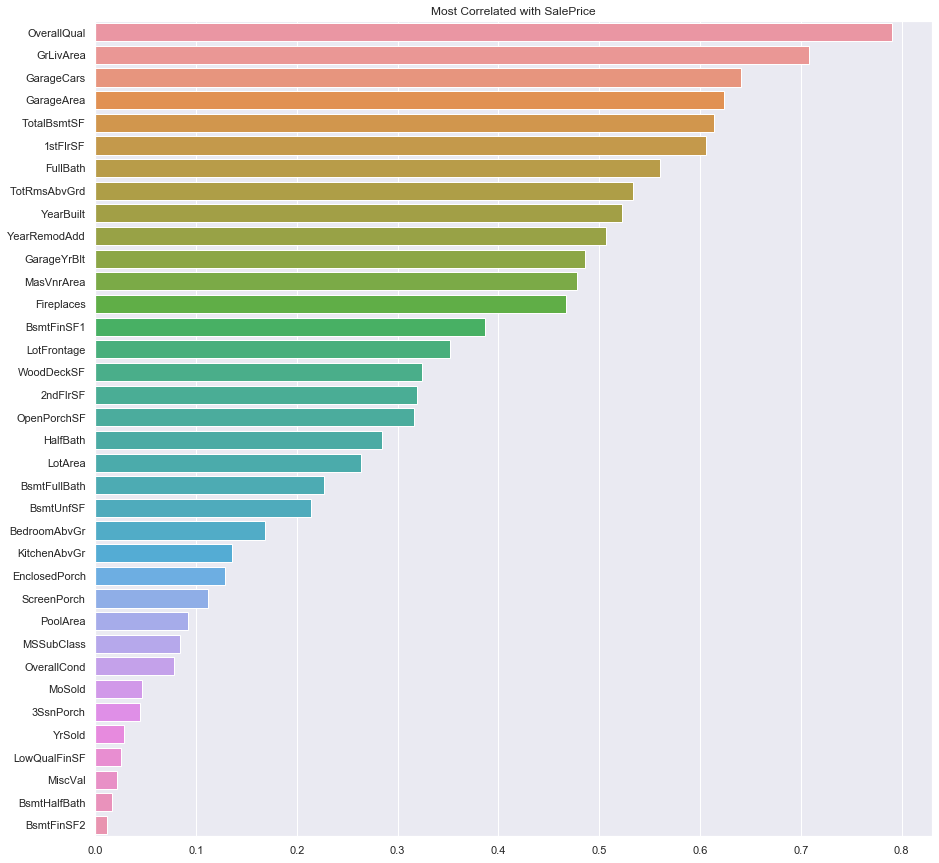

In [146]:
plt.figure(figsize=(15,15))
correlations =train.corr().abs()['SalePrice'].sort_values(ascending=False)[1:]
ax = sns.barplot(x=correlations.values,y=correlations.index).set_title('Most Correlated with SalePrice')

In [149]:
correlations.index[0]

'OverallQual'

Text(0.5, 1.0, 'OverallQual vs SalePrice')

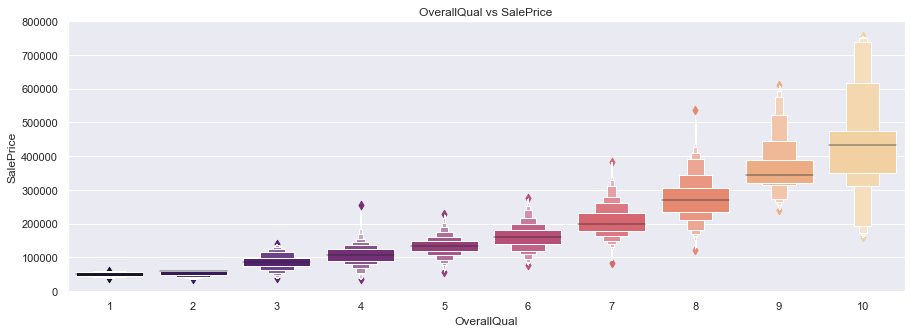

In [159]:
plt.figure(figsize=(15,5))

sns.boxenplot(x=train['OverallQual'], y=train['SalePrice'], palette='magma')
plt.title("OverallQual vs SalePrice")

Text(0.5, 1.1, 'Above Ground Living Area vs Sale Price')

<Figure size 1080x1080 with 0 Axes>

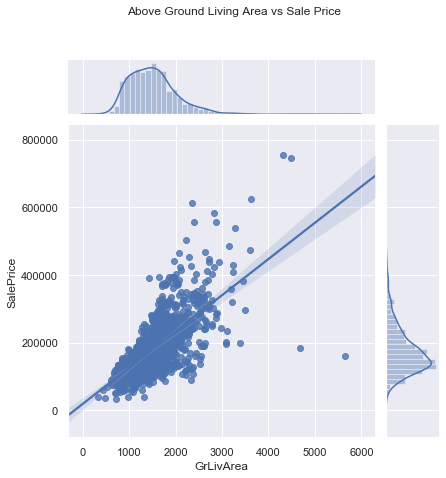

In [165]:
plt.figure(figsize = (15,15))
g = sns.jointplot(data=train, x=train[correlations.index[1]], y=train['SalePrice'], kind='reg')

g.fig.suptitle("Above Ground Living Area vs Sale Price", y=1.1)

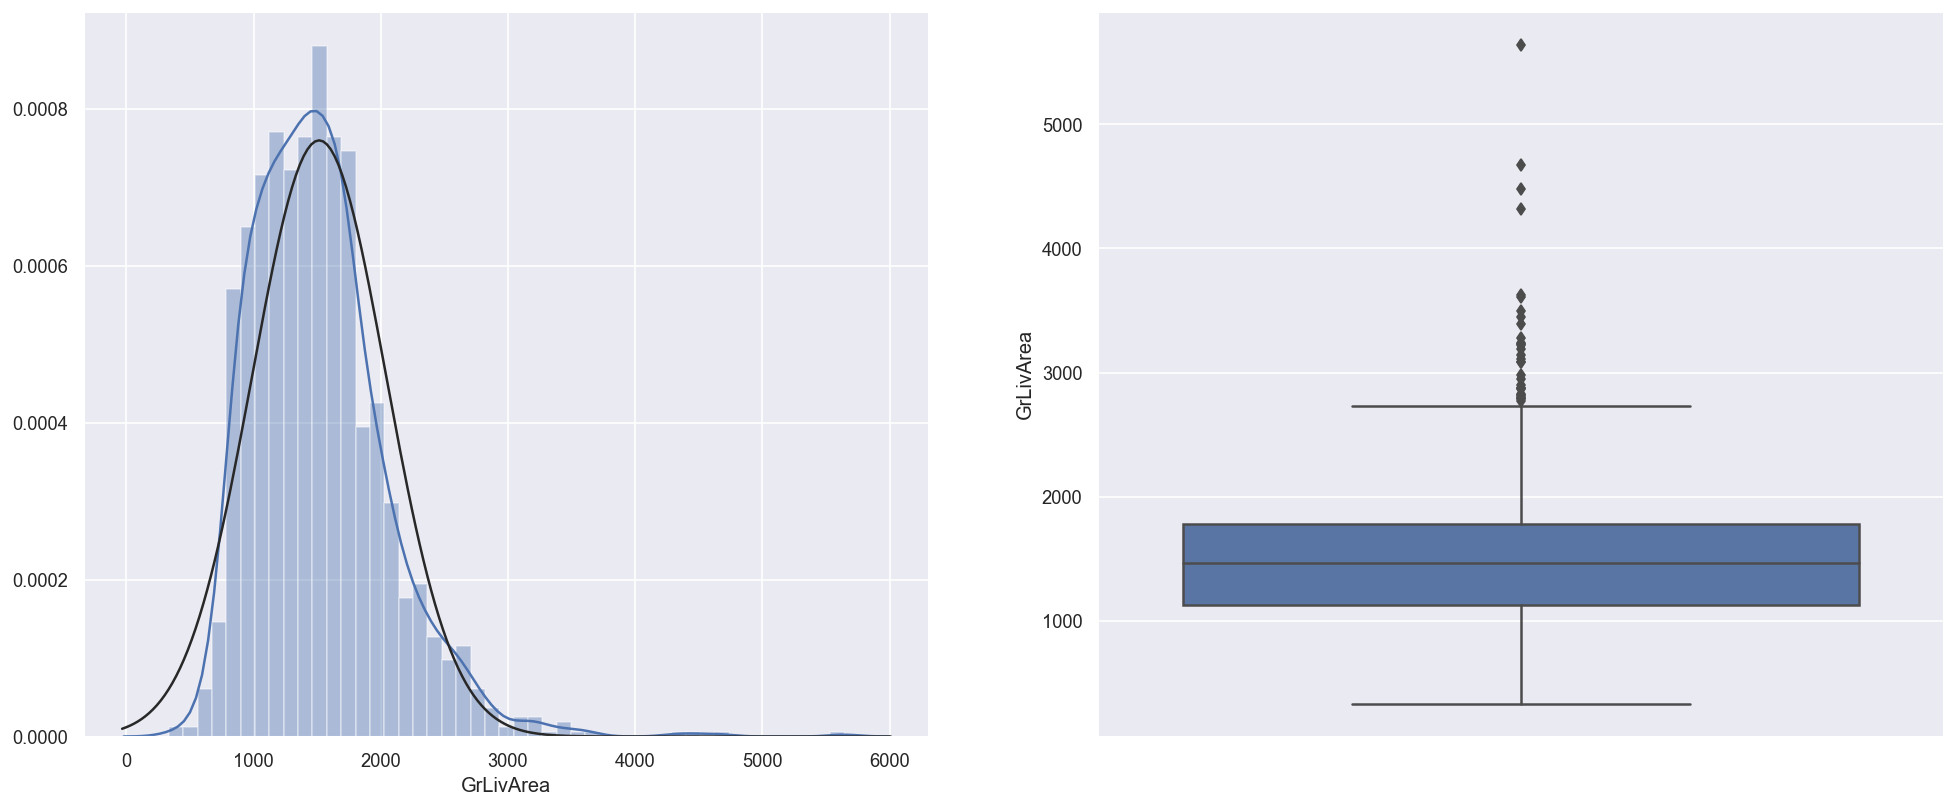

In [65]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), dpi=120)
sns.distplot(train['GrLivArea'].dropna(), fit=norm, ax=ax1)
sns.boxplot(train['GrLivArea'].dropna(), ax=ax2, orient='v')

In [128]:
train.index[(train['GrLivArea']>4500) & (train['SalePrice']<250000)]

Int64Index([523, 1298], dtype='int64')

In [129]:
drop_train = train.drop([523, 1298], axis=0)

Text(0.5, 1.1, 'Above Ground Living Area vs Sale Price With Outliers Removed')

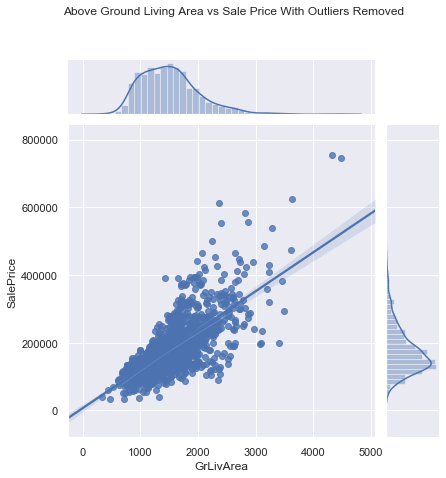

In [131]:
#Plotting new distribution
g = sns.jointplot(data=drop_train, x=drop_train['GrLivArea'], y=drop_train['SalePrice'], kind='reg')

g.fig.suptitle("Above Ground Living Area vs Sale Price With Outliers Removed", y=1.1)

# 缺失值描述

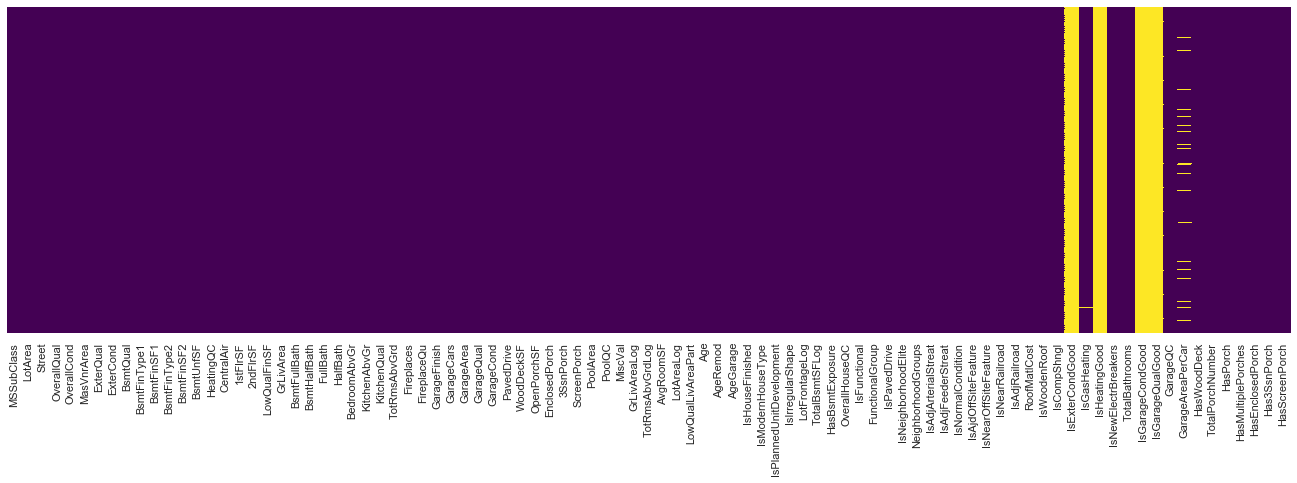

In [200]:
plt.figure(figsize=(23,6))

sns.heatmap(X_train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

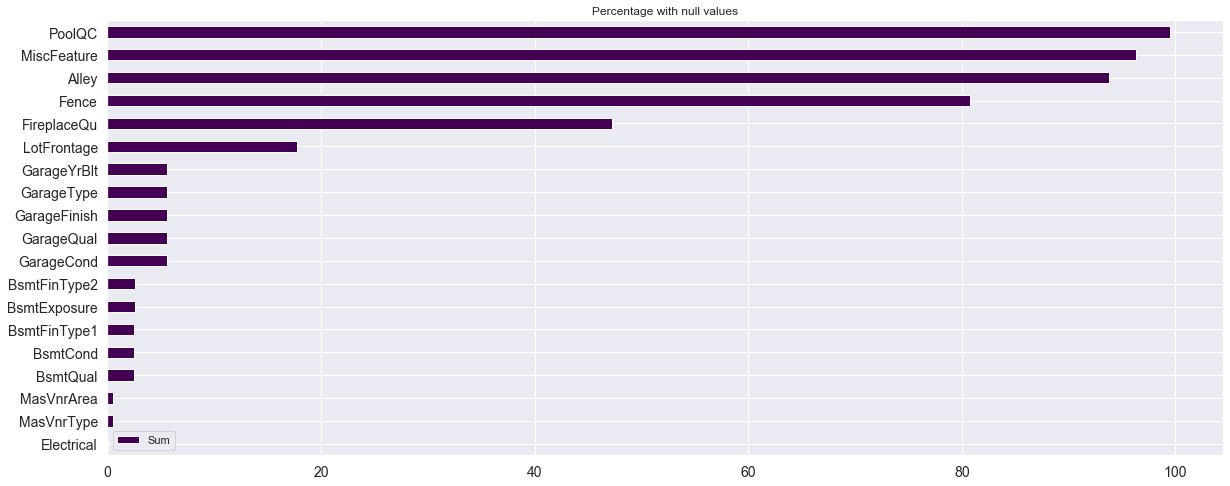

In [23]:
nindex, nfeatures = train.shape
df_null_count = train.isnull().sum().to_frame().rename({0:"Sum"}, axis=1)

df_null_count = df_null_count[df_null_count['Sum'] > 0]

df_null_count['Sum'] = df_null_count['Sum']*(100/nindex)

df_null_count.sort_values(by="Sum", ascending=True).plot(
    kind='barh', figsize=(20,8), fontsize=14, colormap="viridis", title="Percentage with null values"
)
plt.show()

Skewness value: 2.16


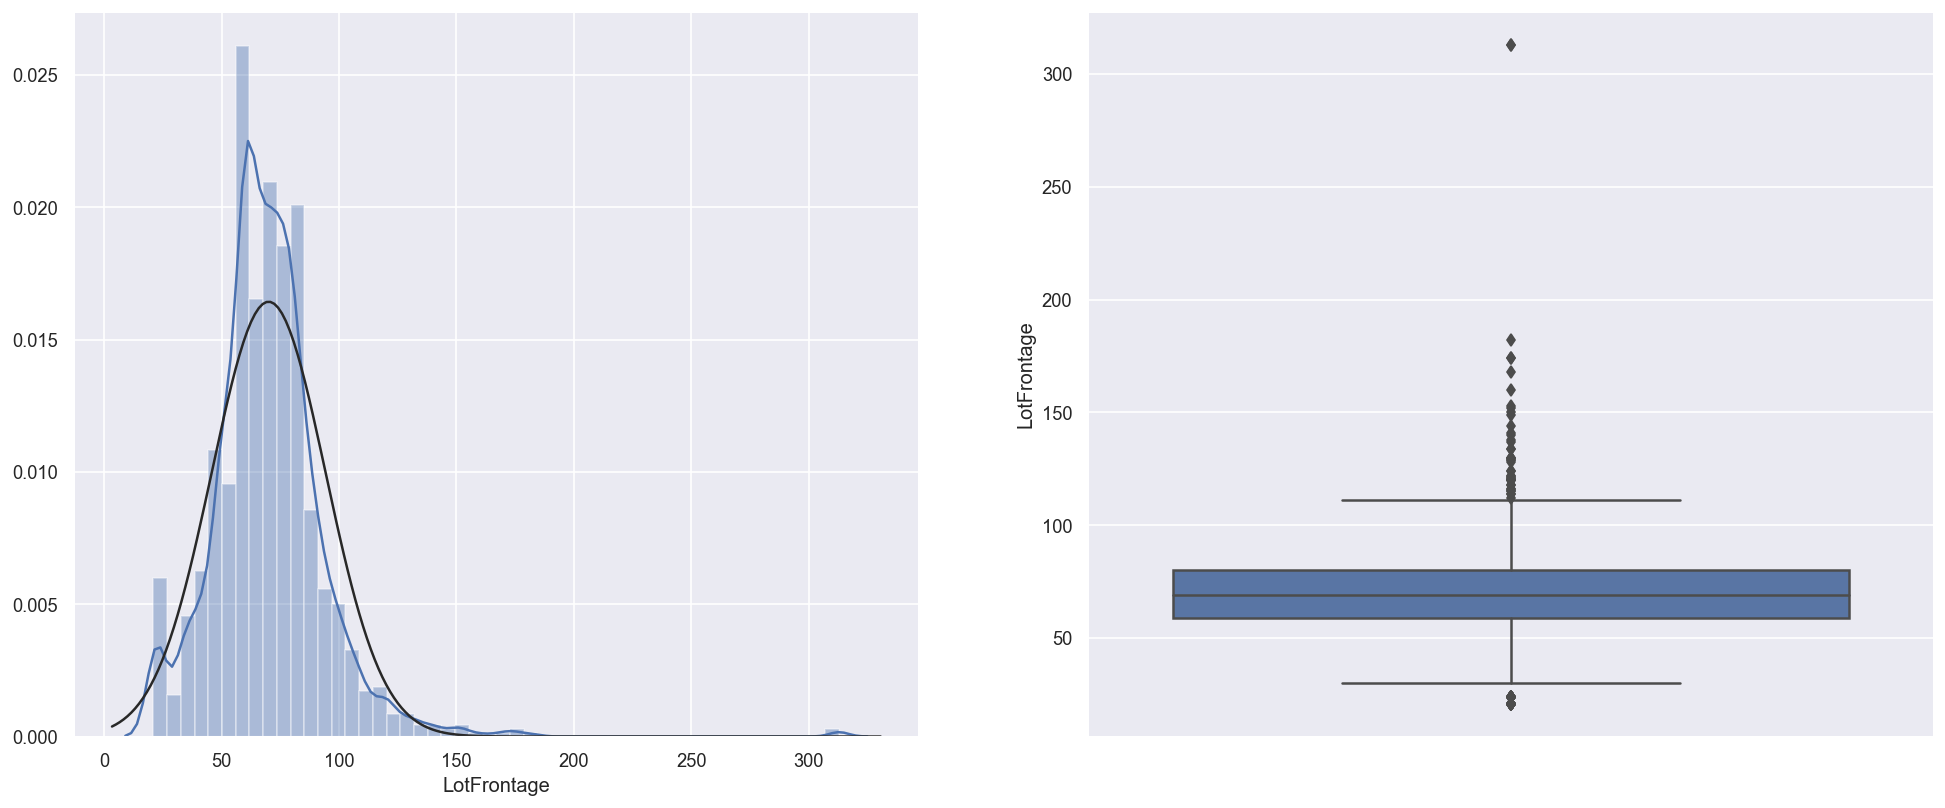

In [63]:
from scipy.stats import norm, skew
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), dpi=120)

sns.distplot(train['LotFrontage'].dropna(), fit=norm, ax=ax1)
sns.boxplot(train['LotFrontage'].dropna(), ax=ax2, orient='v')

print(f"Skewness value: %.2f" %train['LotFrontage'].dropna().skew())

In [ ]:
plt.figure(figsize = (15,15))
g = sns.jointplot(data=train, x=train['LotFrontage'], y=train['SalePrice'], kind='reg')

g.fig.suptitle("Above Ground Living Area vs Sale Price", y=1.1)

# 缺失值填充以及特征编码

In [11]:
no_missing_train = train.copy()
no_missing_test = test.copy()

quality_map = {"None": 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 4}

for feature in (
    'PoolQC',
    'MiscFeature',
    'Alley',
    'Fence',
    'FireplaceQu',
    'BsmtQual', 
    'BsmtCond', 
    'BsmtExposure', 
    'BsmtFinType1', 
    'BsmtFinType2',
    'GarageType', 
    'GarageFinish', 
    'GarageQual', 
    'GarageCond',
    'BsmtQual', 
    'BsmtCond', 
    'BsmtExposure', 
    'BsmtFinType1', 
    'BsmtFinType2',
    'MasVnrType',
):
    no_missing_train[feature] = no_missing_train[feature].fillna('None')
    no_missing_test[feature] = no_missing_test[feature].fillna('None')

for feature in (
    'BsmtFinSF1', 
    'BsmtFinSF2', 
    'BsmtUnfSF',
    'TotalBsmtSF', 
    'BsmtFullBath', 
    'BsmtHalfBath',
    'MasVnrArea',
    'GarageCars',
    'GarageArea',
    'GarageYrBlt',
):
    no_missing_train[feature] = no_missing_train[feature].fillna(0)
    no_missing_test[feature] = no_missing_test[feature].fillna(0)

for feature in (
    'Electrical', 
    'KitchenQual', 
    'Exterior1st',
    'Exterior2nd', 
    'SaleType',
):
    no_missing_train[feature] = no_missing_train[feature].fillna(no_missing_train[feature].mode()[0])
    no_missing_test[feature] = no_missing_test[feature].fillna(no_missing_test[feature].mode()[0])

for dataframe in [no_missing_train, no_missing_test]:
    dataframe['MSZoning'] = dataframe.groupby(['Neighborhood'])['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
    dataframe['MSSubClass'] = dataframe.groupby(['HouseStyle'])['MSSubClass'].transform(lambda x: x.fillna(x.mode()[0]))
    dataframe['LotFrontage'] = dataframe.groupby(['BldgType'])['LotFrontage'].transform(lambda x: x.fillna(x.median()))
    dataframe['Functional'] = dataframe['Functional'].fillna('Typ')
    dataframe.drop('Utilities', inplace=True, axis=1)

#特征编码
ordinal_cat_mapping = {
    'ExterQual': {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}, 
    'ExterCond': {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
    'BsmtQual': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'BsmtCond': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'BsmtFinType1': {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6},
    'BsmtFinType2': {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6},
    'HeatingQC': {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
    'KitchenQual': {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
    'FireplaceQu': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'GarageFinish': {'None': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3},
    'GarageQual': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'GarageCond': {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'PavedDrive': {'N': 0, 'P': 1, 'Y': 2},
    'CentralAir': {'N': 0, 'Y': 1},
    'Street': {'Pave': 0, 'Grvl': 1},
    'PoolQC':{"None": 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 4},
}

for ordinal_feature, feature_mapping in ordinal_cat_mapping.items():
    no_missing_train[ordinal_feature].replace(feature_mapping, inplace = True)
    no_missing_test[ordinal_feature].replace(feature_mapping, inplace = True)

cat_features = [f for f in no_missing_train.columns if no_missing_train.dtypes[f] == 'object']

enc_cat_features = []
non_ordinal_cat_features = list(set(cat_features) - set(ordinal_cat_mapping.keys()))

# 特征工程1

In [12]:
#Living Area
for dataframe in [no_missing_train, no_missing_test]:
    dataframe['GrLivAreaLog'] = np.log(no_missing_train['GrLivArea'])
    dataframe['TotRmsAbvGrdLog'] = np.log(dataframe['TotRmsAbvGrd'])
    dataframe['AvgRoomSF'] = dataframe['GrLivArea'] / dataframe['TotRmsAbvGrd']
    dataframe['LotAreaLog'] = np.log(dataframe['LotArea'])
    dataframe['LowQualLivAreaPart'] = np.log1p(dataframe['LowQualFinSF'] / dataframe['GrLivArea'])
    dataframe['Age'] = dataframe.YrSold - dataframe.YearBuilt
    dataframe['AgeRemod'] = dataframe.YrSold - dataframe.YearRemodAdd
    dataframe['GarageYrBlt'].replace({0.0: np.nan}, inplace=True)
    dataframe['GarageYrBlt'].fillna(dataframe['YrSold'], inplace=True)
    dataframe['AgeGarage'] = dataframe.YrSold - dataframe.GarageYrBlt
    
    dataframe.Age =  dataframe.Age.map(lambda x: 0 if x < 0 else x)
    dataframe.AgeRemod  =  dataframe.AgeRemod.map(lambda x: 0 if x < 0 else x)
    dataframe.AgeGarage =  dataframe.AgeGarage.map(lambda x: 0 if x < 0 else x)

    dataframe.drop(
        ['YrSold','YearBuilt','YearRemodAdd','GarageYrBlt', 'MoSold'], 
        axis=1, inplace=True
    )

## 画图函数用来寻找异常样本

In [13]:
#Analysis Numeric Features
def plot_numeric_features(feature):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), dpi=110)

    sns.distplot(no_missing_train[feature], ax=ax1)
    sns.scatterplot(no_missing_train[feature], no_missing_train["SalePrice"], ax=ax2)
    sns.boxplot(no_missing_train[feature], ax=ax3, orient='v', width=0.2)

    print("Skewness Coefficient of LotFrontage is %.2f" %no_missing_train[feature].skew())
    ax1.set_yticks([])
    
    return plt


# 寻找异常样本

Skewness Coefficient of LotFrontage is 2.27


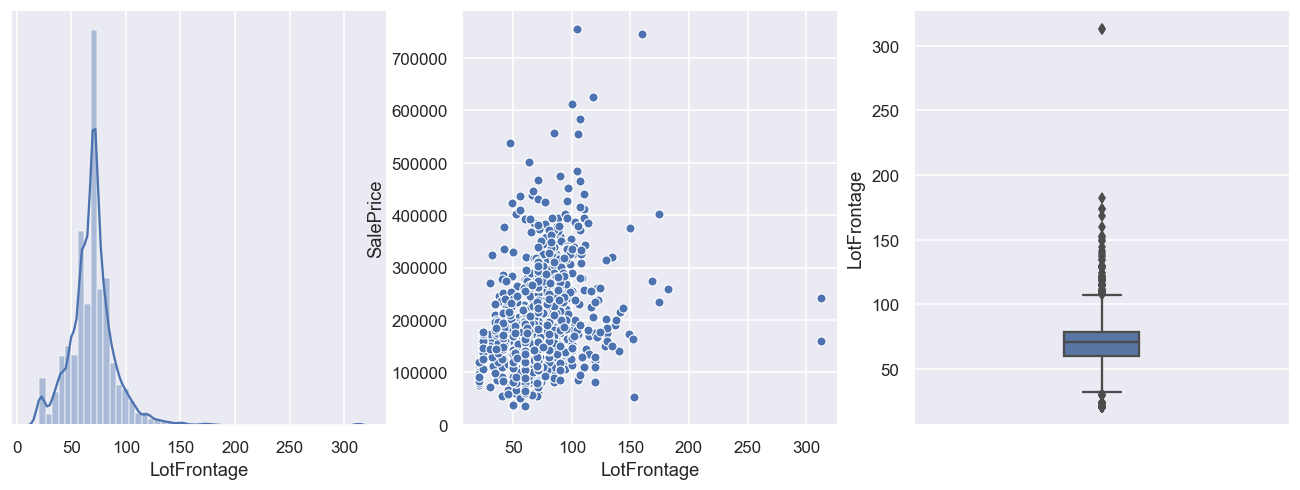

In [44]:
plot_numeric_features("LotFrontage").show()

In [15]:
drop_index = no_missing_train['LotFrontage'][no_missing_train['LotFrontage'] > 300].index

Skewness Coefficient of LotFrontage is 12.21


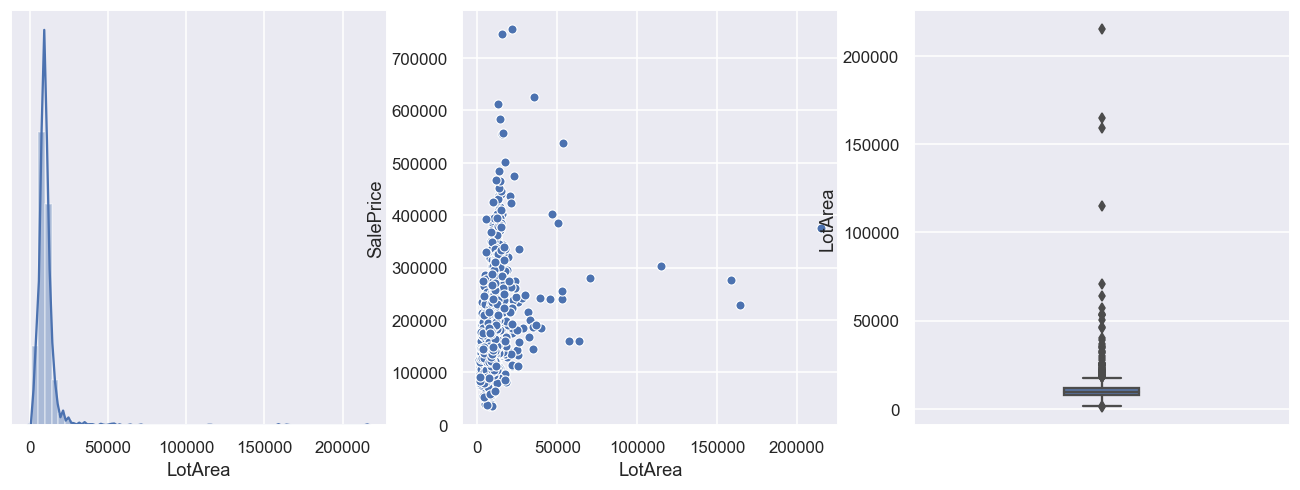

In [52]:
plot_numeric_features("LotArea").show()

In [16]:
drop_index = np.append(drop_index, no_missing_train['LotArea'][no_missing_train['LotArea'] > 100000].index)

Skewness Coefficient of LotFrontage is 1.69


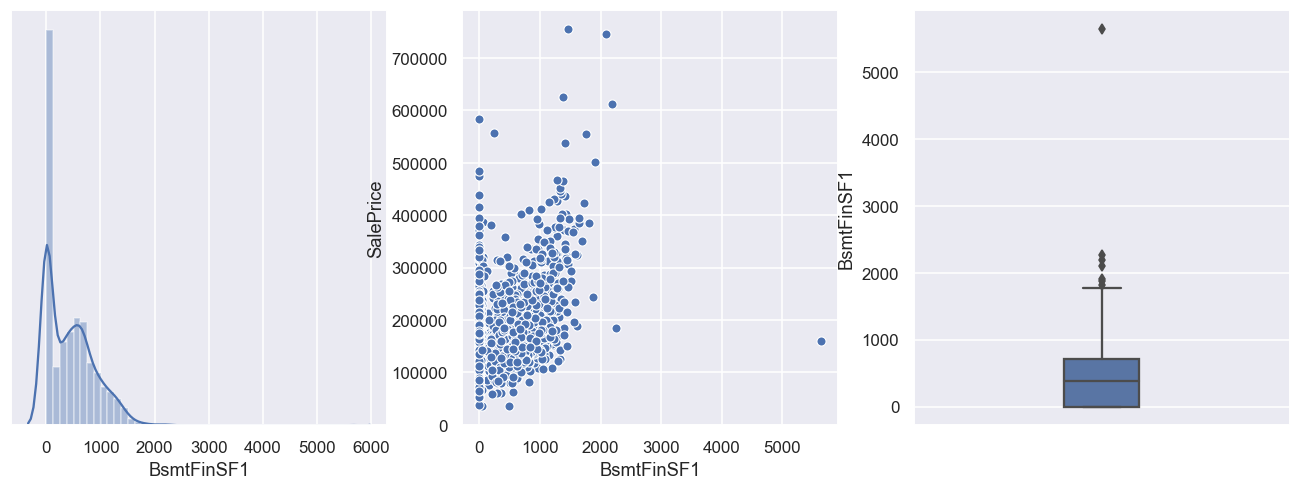

In [57]:
plot_numeric_features("BsmtFinSF1").show()

In [18]:
drop_index = np.append(drop_index, no_missing_train['BsmtFinSF1'][no_missing_train['BsmtFinSF1'] > 5000].index)

Skewness Coefficient of LotFrontage is 1.52


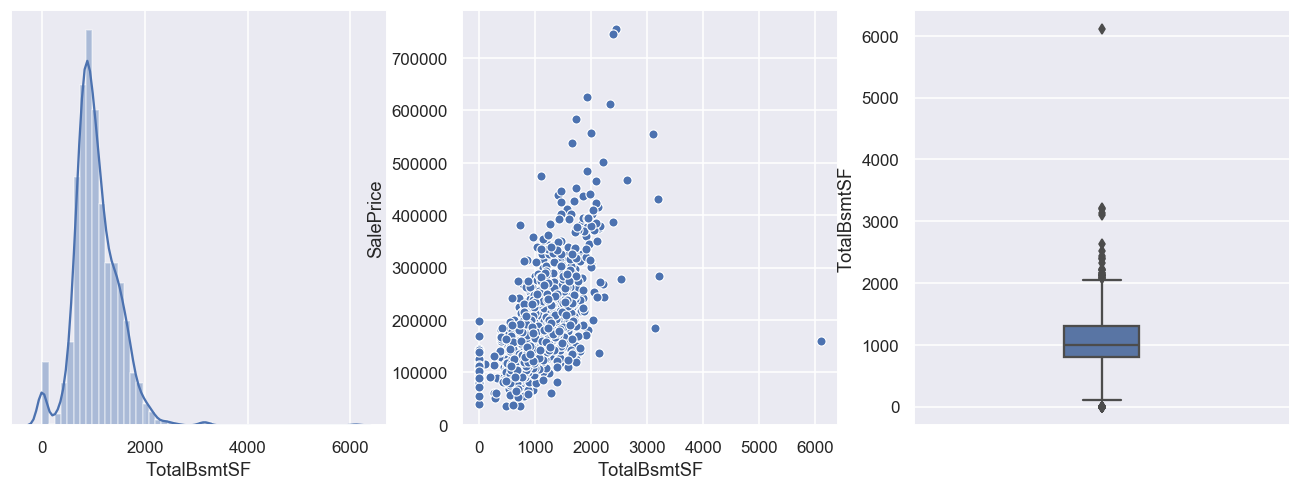

In [59]:
plot_numeric_features("TotalBsmtSF").show()

In [17]:
drop_index = np.append(drop_index, no_missing_train['TotalBsmtSF'][no_missing_train['TotalBsmtSF'] > 6000].index)

Skewness Coefficient of LotFrontage is 1.38


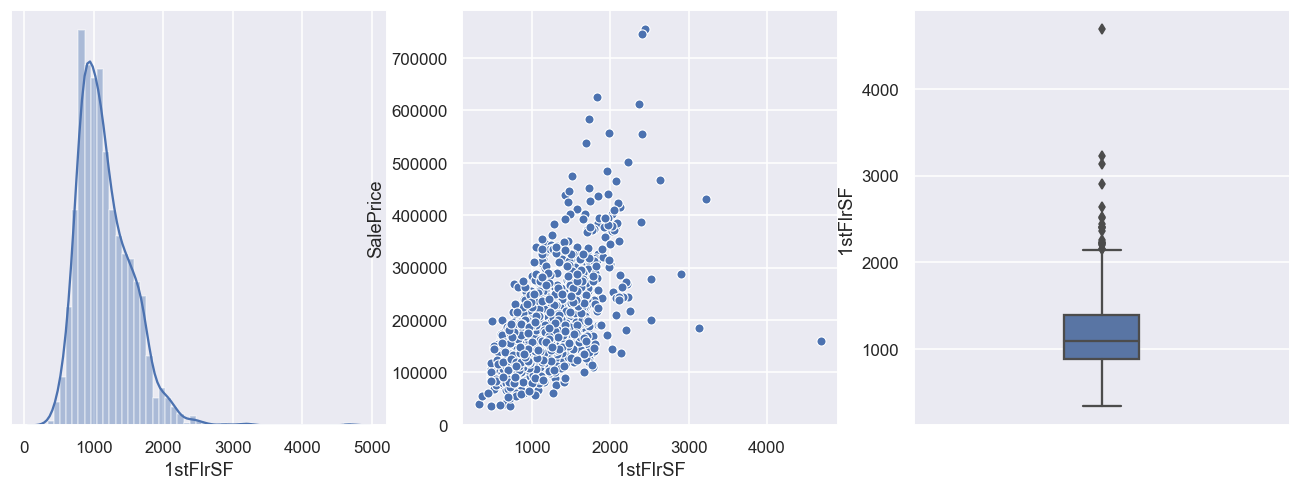

In [63]:
plot_numeric_features("1stFlrSF").show()

In [64]:
drop_index = np.append(drop_index, no_missing_train['1stFlrSF'][no_missing_train['1stFlrSF'] > 4000].index)

Skewness Coefficient of LotFrontage is 1.37


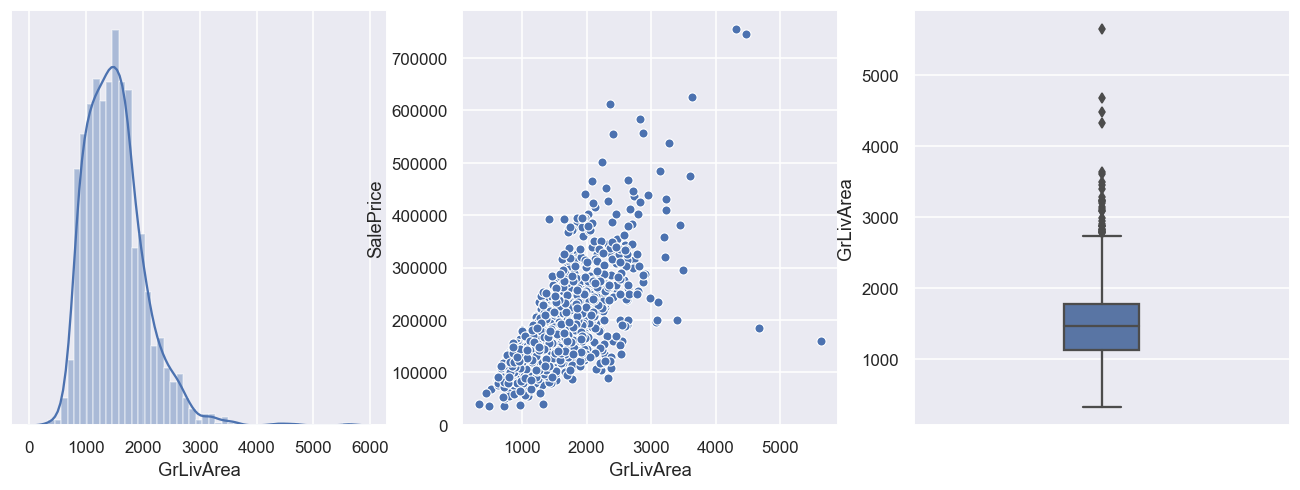

In [65]:
plot_numeric_features("GrLivArea").show()

In [19]:
drop_index = np.append(drop_index, no_missing_train['GrLivArea'][
    (no_missing_train['GrLivArea'] > 4000) & (no_missing_train['SalePrice'] < 12.5)
].index)

In [14]:
no_missing_train.select_dtypes(['float'])

LotFrontage  MasVnrArea  GrLivAreaLog  TotRmsAbvGrdLog   AvgRoomSF  \
0            65.0       196.0      7.444249         2.079442  213.750000   
1            80.0         0.0      7.140453         1.791759  210.333333   
2            68.0       162.0      7.487734         1.791759  297.666667   
3            60.0         0.0      7.448334         1.945910  245.285714   
4            84.0       350.0      7.695303         2.197225  244.222222   
...           ...         ...           ...              ...         ...   
1455         62.0         0.0      7.406711         1.945910  235.285714   
1456         85.0       119.0      7.636752         1.945910  296.142857   
1457         66.0         0.0      7.757906         2.197225  260.000000   
1458         68.0         0.0      6.982863         1.609438  215.600000   
1459         75.0         0.0      7.135687         1.791759  209.333333   

      LotAreaLog  LowQualLivAreaPart  AgeGarage  
0       9.041922                 0.0        5.0  
1       9.169518                 0.0       31.0  
2       9.328123                 0.0        7.0  
3       9.164296                 0.0        8.0  
4       9.565214                 0.0        8.0  
...          ...                 ...        ...  
1455    8.976768                 0.0        8.0  
1456    9.486076                 0.0       32.0  
1457    9.109636                 0.0       69.0  
1458    9.181632                 0.0       60.0  
1459    9.204020                 0.0       43.0  

[1460 rows x 8 columns]

Skewness Coefficient of LotFrontage is -0.14


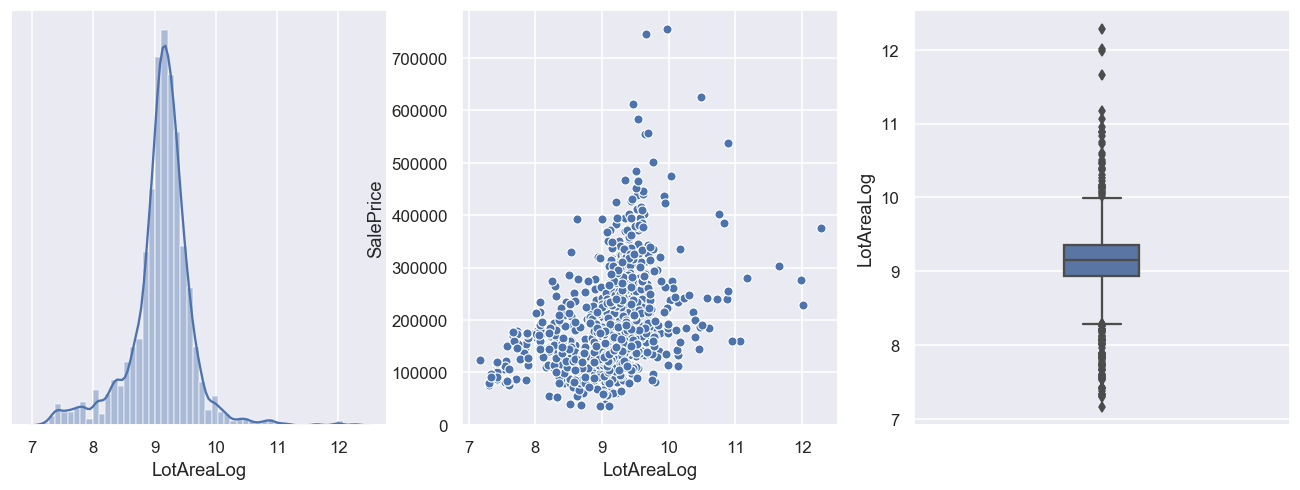

In [381]:
plot_numeric_features("LotAreaLog").show()

Skewness Coefficient of LotFrontage is -5.15


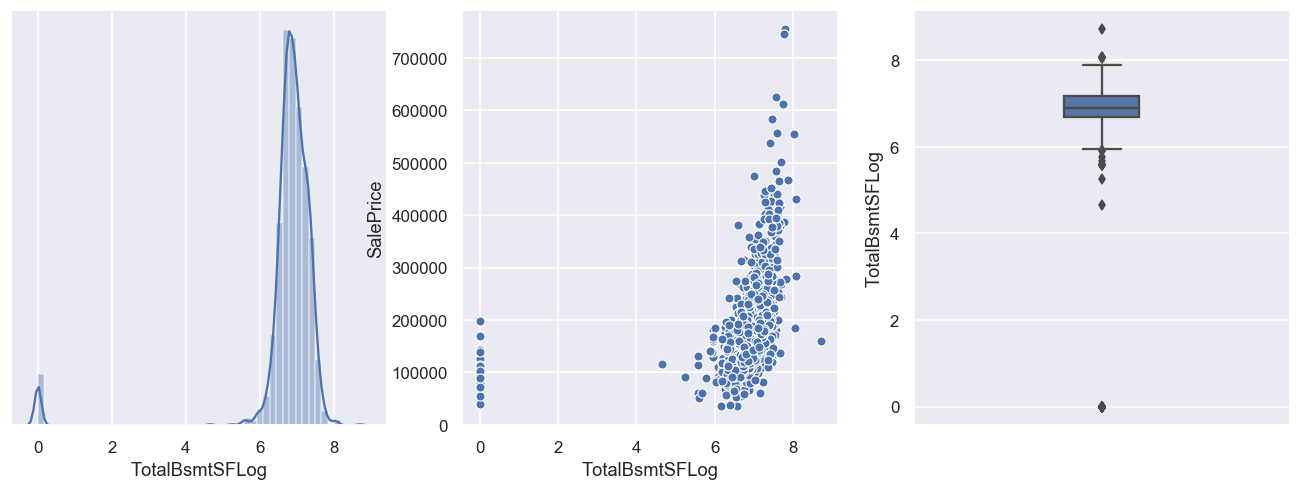

In [382]:
plot_numeric_features("TotalBsmtSFLog").show()

# 特征工程

In [20]:
#House Types
no_missing_train['IsHouseFinished'] = (no_missing_train['HouseStyle'].isin(['2Story', '1Story', '1.5Fin', 'SFoyer', 'SLvl', '2.5Fin'])) * 1
no_missing_test['IsHouseFinished'] = (no_missing_test['HouseStyle'].isin(['2Story', '1Story', '1.5Fin', 'SFoyer', 'SLvl', '2.5Fin'])) * 1

no_missing_train['IsModernHouseType'] = no_missing_train['MSSubClass'].map({
    20: 1, 
    30: 0, 
    40: 0, 
    45: 0, 
    50: 0, 
    60: 1, 
    70: 0, 
    75: 0,
    80: 0, 
    85: 0, 
    90: 0, 
    120: 1, 
    150: 0, 
    160: 1, 
    180: 0, 
    190: 0,
})

no_missing_test['IsModernHouseType'] = no_missing_test['MSSubClass'].map({
    20: 1, 
    30: 0, 
    40: 0, 
    45: 0, 
    50: 0, 
    60: 1, 
    70: 0, 
    75: 0,
    80: 0, 
    85: 0, 
    90: 0, 
    120: 1, 
    150: 0, 
    160: 1, 
    180: 0, 
    190: 0,
})

no_missing_train['IsPlannedUnitDevelopment'] = no_missing_train['MSSubClass'].map({
    20: 0, 
    30: 0, 
    40: 0, 
    45: 0, 
    50: 0, 
    60: 0, 
    70: 0, 
    75: 0,
    80: 0, 
    85: 0, 
    90: 0, 
    120: 1, 
    150: 1, 
    160: 1, 
    180: 1, 
    190: 0,
})

no_missing_test['IsPlannedUnitDevelopment'] = no_missing_test['MSSubClass'].map({
    20: 0, 
    30: 0, 
    40: 0, 
    45: 0, 
    50: 0, 
    60: 0, 
    70: 0, 
    75: 0,
    80: 0, 
    85: 0, 
    90: 0, 
    120: 1, 
    150: 1, 
    160: 1, 
    180: 1, 
    190: 0,
})

#LotShape
for dataframe in [no_missing_train, no_missing_test]:
    dataframe['IsIrregularShape'] = dataframe['LotShape'].map({
        'Reg': 0,
        'IR1': 1,
        'IR2': 1,
        'IR3': 1,
    })
    dataframe['LotFrontageLog'] = np.log(dataframe['LotFrontage'])
    dataframe.drop(['LotFrontage'], axis = 1, inplace = True)

#LandSlope
for dataframe in [no_missing_train, no_missing_test]:
    dataframe['TotalBsmtSFLog'] = np.log1p(dataframe['TotalBsmtSF'])
    dataframe.drop(['TotalBsmtSF'], axis = 1, inplace = True)
    dataframe['BsmtQC'] = dataframe['BsmtQual'] + dataframe['BsmtCond']

    dataframe['HasBsmtExposure'] = dataframe['BsmtExposure'].map({
        'None': 0,
        'No': 0,
        'Mn': 1,
        'Av': 1,
        'Gd': 1
    })

for dataframe in [no_missing_train, no_missing_test]:
    dataframe['OverallHouseQC'] = dataframe['OverallCond'] + dataframe['OverallQual']
    dataframe['OverallHouseQCBins'] = pd.qcut(dataframe['OverallHouseQC'], q=3)

    dataframe['IsFunctional'] = (dataframe['Functional'] == 'Typ') * 1
    dataframe['FunctionalGroup'] = dataframe['Functional'].map({
        'Typ': 2,
        'Min1': 1,
        'Min2': 1,
        'Mod': 1,
        'Maj1': 0,
        'Maj2': 0,
        'Sev': 0,
        'Sav': 0,
    })
    dataframe.drop(['Functional'], axis = 1, inplace = True)

    #Neighborhood
    dataframe['IsPavedDrive'] = (dataframe['PavedDrive'] == 'Y') * 1

    dataframe['IsNeighborhoodElite'] = (dataframe['Neighborhood'].isin(['NridgHt', 'CollgeCr', 'Crawfor', 'StoreBr', 'Timber'])) * 1

    dataframe['NeighborhoodGroups'] = dataframe['Neighborhood'].map({
        'MeadowV': 0,
        'IDOTRR': 1,
        'BrDale': 1,
        'OldTown': 1,
        'Edwards': 1,
        'BrkSide': 1,
        'Sawyer': 1,
        'Blueste': 1,
        'SWISU': 2,
        'NAmes': 2,
        'NPkVill': 2,
        'Mitchel': 2,
        'SawyerW': 2,
        'Gilbert': 2,  
        'NWAmes': 2,   
        'Blmngtn': 2,  
        'CollgCr': 2,  
        'ClearCr': 3,  
        'Crawfor': 3,  
        'Veenker': 3,  
        'Somerst': 3,  
        'Timber': 3,   
        'StoneBr': 4, 
        'NoRidge': 4, 
        'NridgHt': 4,
    })
    dataframe['IsAdjArterialStreat'] = ((dataframe['Condition1'] == 'Artery') | (dataframe['Condition2'] == 'Artery')) * 1
    dataframe['IsAdjFeederStreat'] = ((dataframe['Condition1'] == 'Feedr') | (dataframe['Condition2'] == 'Feedr')) * 1
    dataframe['IsNormalCondition'] = ((dataframe['Condition1'] == 'Norm') | (dataframe['Condition2'] == 'Norm')) * 1
    dataframe['IsAjdOffSiteFeature'] = ((dataframe['Condition1'] == 'PosA') | (dataframe['Condition2'] == 'PosA')) * 1
    dataframe['IsNearOffSiteFeature'] = ((dataframe['Condition1'] == 'PosN') | (dataframe['Condition2'] == 'PosN')) * 1
    dataframe['IsNearRailroad'] = ((dataframe['Condition1'].isin(['RRNn', 'RRNe'])) | (dataframe['Condition2'].isin(['RRNn', 'RRNe']))) * 1
    dataframe['IsAdjRailroad'] = ((dataframe['Condition1'].isin(['RRAn', 'RRAe'])) | (dataframe['Condition2'].isin(['RRAn', 'RRAe']))) * 1
    dataframe.drop(['Condition1','Condition2'], axis = 1, inplace = True)

#Roof Properties
for dataframe in [no_missing_train, no_missing_test]:
    dataframe['RoofMatlCost'] = dataframe['RoofMatl'].map({
        'CompShg':0,
        'WdShake': 1,
        'ClyTile': 1,
        'WdShngl': 1,
        'Roll': 0,
        'Metal': 1,
        'Membran': 0,
        'Tar&Grv': 0,
    })

    dataframe['IsWoodenRoof'] = dataframe['RoofMatl'].map({
        'CompShg': 0,
        'WdShake': 1,
        'ClyTile': 0,
        'WdShngl': 1,
        'Roll': 0,
        'Metal': 0,
        'Membran': 0,
        'Tar&Grv': 0,
    })

    dataframe['IsCompShngl'] = dataframe['RoofMatl'].map({
        'CompShg': 1,
        'WdShake': 0,
        'ClyTile': 0,
        'WdShngl': 0,
        'Roll': 0,
        'Metal': 0,
        'Membran': 0,
        'Tar&Grv': 0,
    })
    #House Exterior Coverage
    dataframe['MasVnrAreaGroups'] = pd.cut(dataframe['MasVnrArea'], bins=[-1, 1, 200, 400, 800, 1700], labels=[0, 1, 2, 3, 4]).astype(int)
    #Heating
    dataframe['IsGasHeating'] = dataframe['Heating'].map({'GasA': 1, 'GasW': 1, 'Grav': 0, 'Wall': 0, 'OtherW': 0, 'Floor': 0})
    dataframe['IsGasHeating'].fillna(0, inplace = True)

    dataframe.drop(['RoofMatl','Heating'], axis = 1, inplace = True)

for dataframe in [no_missing_train, no_missing_test]:
    dataframe['IsNewElectrBreakers'] = dataframe['Electrical'].map({'SBrkr': 1, 'FuseF': 0, 'FuseA': 0, 'FuseP': 0, 'Mix': 0})

    #Kitchen
    #dataframe['KitchenQC'] = pd.cut(dataframe['KitchenQual'] * dataframe['KitchenAbvGr'], [0, 2, 6])

    #Bathrooms
    dataframe['TotalBathrooms'] = dataframe['FullBath'] + (0.5 * dataframe['HalfBath']) + \
                                    dataframe['BsmtFullBath'] + (0.5 * dataframe['BsmtHalfBath'])

    #Garage
    dataframe['GarageQC'] = dataframe['GarageQual'] + dataframe['GarageCond']

    dataframe['GarageAreaPerCar'] = dataframe['GarageArea'] / dataframe['GarageCars']
    dataframe['GarageAreaPerCar'].fillna(0, inplace = True)

    dataframe['HasWoodDeck'] = (dataframe['WoodDeckSF'] > 0) * 1
    dataframe['WoodDeckGroups'] = pd.cut(dataframe['WoodDeckSF'], bins=[-1, 1, 200, 500, 2000], labels=[0, 1, 2, 3]).astype(int)

    dataframe.drop(['Electrical'], axis = 1, inplace = True)

for dataframe in [no_missing_train, dataframe]:
    dataframe['TotalPorchNumber'] = (dataframe['OpenPorchSF'] > 0) * 1 +(dataframe['EnclosedPorch'] > 0) * 1 + (dataframe['3SsnPorch'] > 0) * 1 + (dataframe['ScreenPorch'] > 0) * 1
    dataframe['HasPorch'] = (dataframe['TotalPorchNumber'] > 0) * 1
    dataframe['HasMultiplePorches'] = (dataframe['TotalPorchNumber'] > 1) * 1

    dataframe['OpenPorchGroups'] = pd.cut(dataframe['OpenPorchSF'], bins=[-1, 1, 40, 70, 1000], labels=[0, 1, 2, 3]).astype(int)

    dataframe['HasEnclosedPorch'] = (dataframe['EnclosedPorch'] > 0) * 1

    dataframe['Has3SsnPorch'] = (dataframe['3SsnPorch'] > 0) * 1

    dataframe['HasScreenPorch'] = (dataframe['ScreenPorch'] > 0) * 1

    dataframe['SaleTypeGroup'] = dataframe['SaleType'].map({
        'WD': 'WD',
        'CWD': 'WD',
        'New': 'New',
        'COD': 'COD',
        'Con': 'Contract',
        'ConLD': 'Contract',
        'ConLw': 'Contract',
        'ConLI': 'Contract',
        'Oth': 'Other'
    })

    dataframe['SaleInteraction'] = dataframe['SaleTypeGroup'] + dataframe['SaleCondition']

    dataframe.drop(['SaleType'], axis = 1, inplace = True)

C:\Users\gybj0\Anaconda3\lib\site-packages\pandas\core\ops\__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


## 查看最终相关性

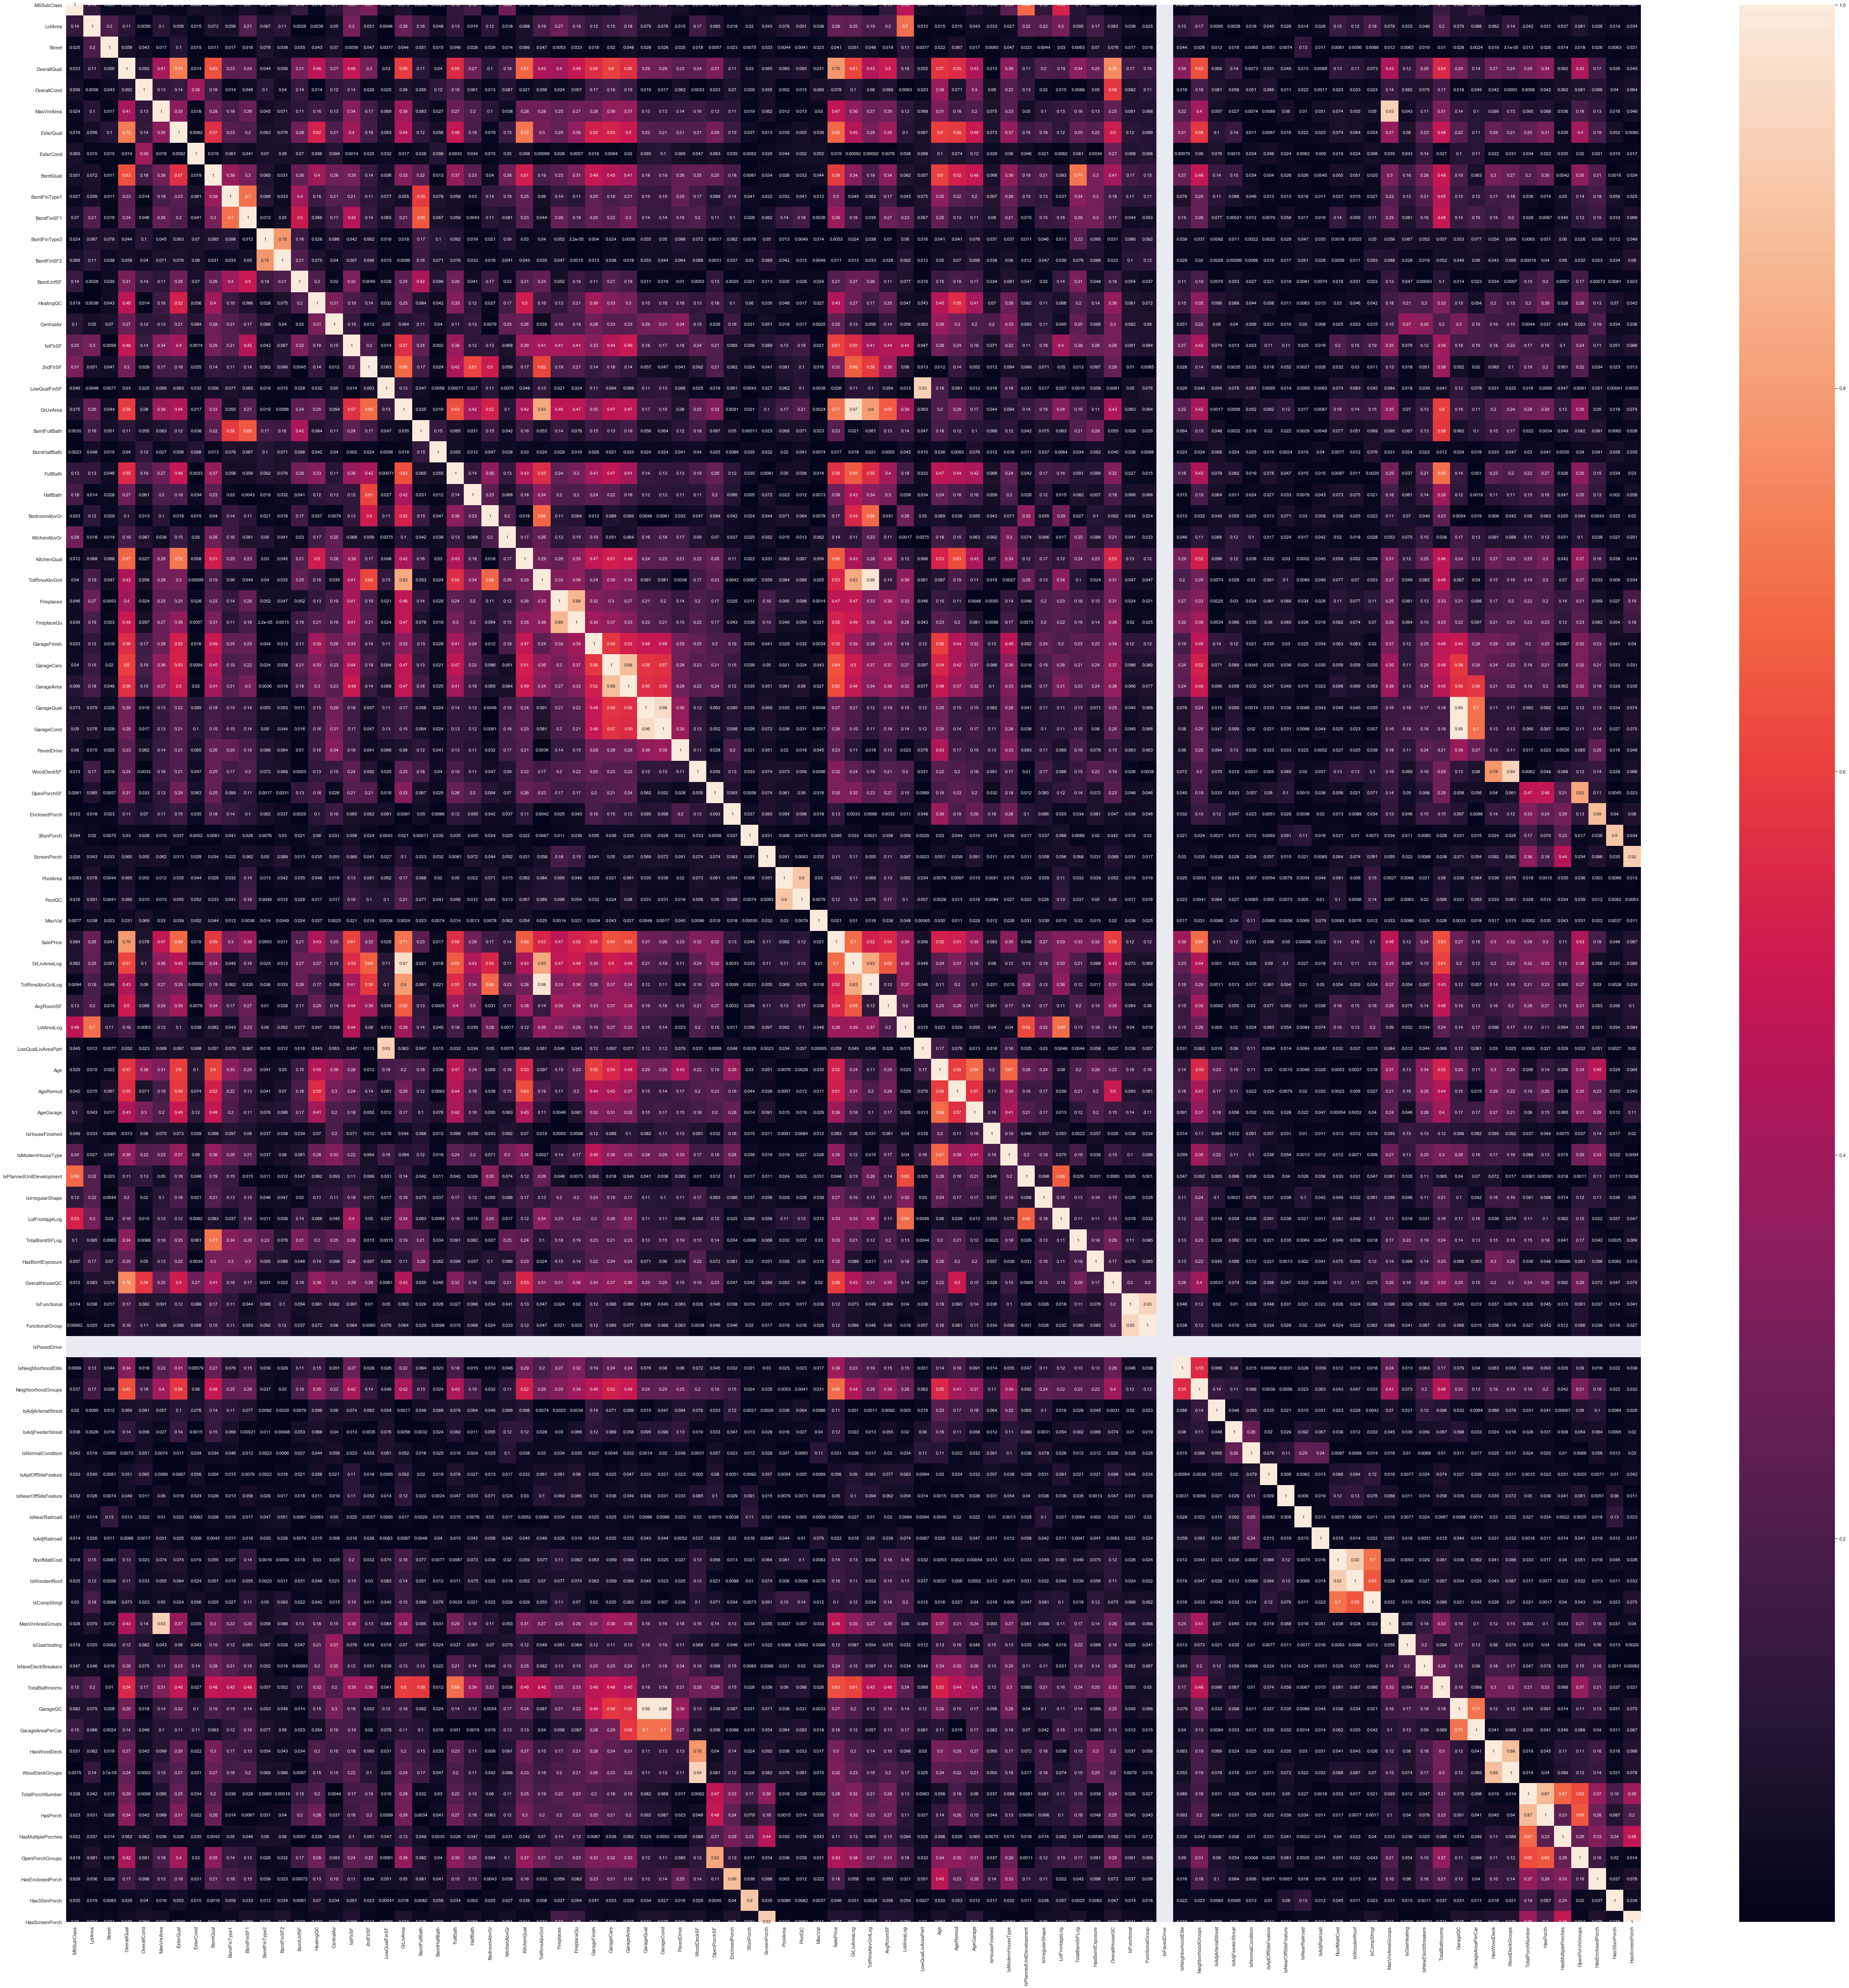

In [370]:
fig, ax = plt.subplots(figsize=(80,80))         # Sample figsize in inches
sns.heatmap(no_missing_train.corr().abs(),annot=True)

# 选择特征

In [23]:
X_train = no_missing_train.drop(no_missing_train.select_dtypes(['object','category']), axis = 1)

X_train.drop(list(set(drop_index)), axis = 0, inplace = True)
y_train = X_train['SalePrice']
X_train.drop(['SalePrice'], axis = 1, inplace = True)

In [24]:
from xgboost import XGBRegressor
xgb = XGBRegressor()

xgb.fit(X_train, y_train)
df_imp = pd.DataFrame(xgb.feature_importances_ , columns = ['Importance'], index=X_train.columns)
df_imp = df_imp.sort_values(['Importance'], ascending = False)

df_imp.head()

Importance
OverallQual           0.371144
NeighborhoodGroups    0.126159
GarageCars            0.082940
TotalBathrooms        0.047801
BsmtQual              0.035631

X_train_eng = train_eng.drop(columns=[y_column]).select_dtypes([int,float,bool])
y_train_eng = train_eng[y_column]
X_test_eng = test_eng.drop(columns=['Id']).select_dtypes([int,float,bool])

In [171]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import scale

In [175]:
bridge_train = no_missing_train.copy()
bridge_test = no_missing_test.copy()

In [176]:
ID = bridge_test['Id']
bridge_test.drop(['Id'], axis = 1, inplace = True)
price = bridge_train['SalePrice']
bridge_train.drop(['SalePrice'], axis = 1, inplace = True)
all_data = pd.concat((bridge_train,bridge_test)).reset_index(drop = True)

## 做特征标签

In [177]:
for discrete_feature in all_data.select_dtypes(['object','category']).columns:
    enc = OneHotEncoder(handle_unknown='ignore')
    enc_pro = enc.fit_transform(all_data[[discrete_feature]]).toarray()
    enc_df = pd.DataFrame(enc_pro, columns = [discrete_feature+str(i) for i in range(len(enc_pro[0]))])
    all_data = all_data.join(enc_df)
    all_data = all_data.drop([discrete_feature],axis = 1)

In [179]:
bridge_test = all_data.loc[1460:]
bridge_train = all_data.loc[:1459]

## 去除异常样本便于训练

In [38]:
train['SalePrice'].drop([523,1298])

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1458, dtype: int64

In [180]:
final_train = bridge_train.copy()

In [181]:
final_train = final_train.drop([523, 1298], axis=0)

In [182]:
final_test = bridge_test.copy()

## 分割训练集 验证集

In [183]:
#no_missing_test.drop(['Id'], axis = 1,inplace = True)
X_train, X_valid, y_train, y_valid = train_test_split(bridge_train.drop(drop_index),np.log(price.drop(drop_index)), test_size=0.3, random_state=42)

#X_train.drop('SalePrice', axis=1, inplace=True)
#X_valid.drop('SalePrice', axis=1, inplace=True)

## 选择模型训练

In [185]:
from sklearn.svm import LinearSVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import GradientBoostingRegressor
import lightgbm as lgb
from sklearn import linear_model

In [192]:
LinearSVRegression = LinearSVR(random_state=0, tol=1e-5)
rf_model = RandomForestRegressor()

lr_model = LinearRegression()

xgb_model = XGBRegressor(gamma=0.01, 
                             learning_rate=0.01, max_depth=6, 
                             min_child_weight=1.5, n_estimators=8000,
                             subsample=0.2,verbosity=0, nthread = -1, random_state = 42,
                        objectice='reg:gamma',booster='gbtree')

gbr_model = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state = 42)

lgbm_regressor= lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11,random_state = 42)

Ridge_regression = linear_model.Ridge(alpha=1.0,normalize=True)

Lasso = linear_model.Lasso(alpha = 0.0005, random_state = 42)
Elastic_net = linear_model.ElasticNet(alpha = 0.0005, l1_ratio = 0.9, random_state = 42)
kernel_ridge= KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

models = [
    rf_model,
    lr_model,
    xgb_model,
    gbr_model,
    lgbm_regressor,
    Ridge_regression,
    #SVRegrssion,
    #LinearSVRegression,
    Lasso,
    Elastic_net,
    kernel_ridge
] 

In [187]:
linear_models = [
    lr_model,
    Ridge_regression,
    Lasso,
    Elastic_net,
    kernel_ridge    
]

boosting_models = [
    xgb_model,
    gbr_model,
    lgbm_regressor
]
for model in boosting_models:
    model.fit(X_train, y_train)
    
predictions = np.column_stack(model.predict(X_valid) for model in boosting_models)

y_pred = np.mean(predictions, axis = 1)

rmse = mean_squared_error(y_valid, y_pred)

print('Bagging rmse:' + str(rmse))

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\Users\gybj0\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.


Bagging rmse:0.012260574148245133


## 调参

In [193]:
from sklearn.metrics import mean_absolute_error, mean_squared_log_error, make_scorer

def neg_rmsle(y_true, y_pred):
    y_pred = np.abs(y_pred)
    
    return -1 * np.sqrt(mean_squared_log_error(y_true, y_pred))

parameters = {
    'xgb_regressor__objective': ['reg:gamma'], # 'reg:squarederror', 'reg:squaredlogerror'
    'xgb_regressor__learning_rate': [0.01],
    'xgb_regressor__n_estimators': [7900, 8000, 8100],
    'xgb_regressor__max_depth': [11, 12, 13],
    'xgb_regressor__booster': ['gbtree'],
    'xgb_regressor__min_child_weight': [1.5],
    'xgb_regressor__gamma': [0],
    'xgb_regressor__subsample': [0.2],
    'xgb_regressor__reg_alpha': [0, 0.9, 1],
    'xgb_regressor__reg_lambda': [1, 0.3],
}

paramSearch = GridSearchCV(
   estimator=xgb_pipeline,
   scoring=make_scorer(neg_rmsle),
   param_grid=parameters,
   cv=2,
   n_jobs=-1, 
   verbose=3
)

final_model = xgb_pipeline.fit(X_train, y_train)


In [143]:
from sklearn.metrics import mean_squared_error
grid_params = {
    'xgb__min_child_weight' : [1, 5, 10],
    'xgb__n_estimators' : [200, 400, 600, 800],
    'xgb__max_depth' : [3,5,7,9],
    'xgb__subsample' : [0.5, 0.7, 0.9],
    'xgb__gamma' : [0.1, 0.5, 1, 1.5, 2],
    'xgb__learning_rate' : [0.02, 0.04, 0.06, 0.08]
}

xgb_model_2 = XGBRegressor()
regressor = GridSearchCV(xgb_model_2, 
                  grid_params,
                  cv = 5,
                  n_jobs = -1,
                  verbose = 5,
                  scoring = 'neg_mean_squared_error'
                  )

final_model = regressor.fit(X_train, y_train)

print(final_model.best_params_)

grid_params = {
    'xgb__min_child_weight' : [1, 5, 10],
    'xgb__n_estimators' : [200, 400, 600, 800],
    'xgb__max_depth' : [3,5,7,9],
    'xgb__subsample' : [0.5, 0.7, 0.9],
    'xgb__gamma' : [0.1, 0.5, 1, 1.5, 2],
    'xgb__learning_rate' : [0.02, 0.04, 0.06, 0.08]
}

xgb_model_2 = XGBRegressor()
regressor = GridSearchCV(xgb_model_2, 
                  grid_params,
                  cv = 5,
                  n_jobs = -1,
                  verbose = 5,
                  scoring = 'neg_mean_squared_error'
                  )

final_model = regressor.fit(X_train, y_train)

print(final_model.best_params_)

Fitting 5 folds for each of 2880 candidates, totalling 14400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   55.0s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 858 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1128 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 2154 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 3018 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 3504 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed: 10.3min
[Parallel(n_jobs=-1)]: Done 4584 tasks      | e

{'xgb__gamma': 0.1, 'xgb__learning_rate': 0.02, 'xgb__max_depth': 3, 'xgb__min_child_weight': 1, 'xgb__n_estimators': 200, 'xgb__subsample': 0.5}


## 初次预测

In [367]:
test_pred = np.column_stack(model.predict(bridge_test) for model in boosting_models)
pred = np.mean(test_pred, axis = 1)
output = pd.DataFrame({'Id': ID,
                       'SalePrice': np.exp(pred)})
output.to_csv('Stacking.csv', index = False)

C:\Users\gybj0\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


## stacking

In [347]:
from sklearn.ensemble import StackingRegressor

estimators = [('xgb_regressor', xgb_model),('gbr_model', gbr_model),('lgbm_model', lgbm_regressor), ('random_forest', rf_model) ]

stack = StackingRegressor(estimators=estimators, final_estimator= Lasso, cv= 5, n_jobs= -1, passthrough = True)

stack.fit(X_train, y_train)

pred = stack.predict(X_valid)

rmse_val = mean_squared_error(y_valid, pred, squared= False) # squared= False > returns Root Mean Square Error    
print(f'rmse= {rmse_val}')

rmse= 0.11048603854465042


## 调参

In [352]:
xgb_model.fit(X_train,y_train)
np.exp(xgb_model.predict(bridge_test))

array([135365.  , 165485.48, 177651.95, ..., 158411.73, 129660.35,
       197510.17], dtype=float32)

## 最终预测

In [351]:
output = pd.DataFrame({'Id': ID,
                       'SalePrice': np.exp(stack.predict(bridge_test))})

In [354]:
output = pd.DataFrame({'Id': ID,
                       'SalePrice': np.exp(xgb_model.predict(bridge_test))})

In [60]:
output = pd.DataFrame({'Id': ID,
                       'SalePrice': np.exp(xgb_pipeline.predict(bridge_test))})

In [61]:
output.to_csv('XGboostbe.csv', index = False)